In [1]:
!pip install utils

  Preparing metadata (setup.py) ... done
  Created wheel for utils: filename=utils-1.0.2-py2.py3-none-any.whl size=13906 sha256=e321d8e6eaf7e074c317d1d32ea2f2388077a4af61f9c513f74af1123db62427
  Stored in directory: /root/.cache/pip/wheels/b8/39/f5/9d0ca31dba85773ececf0a7f5469f18810e1c8a8ed9da28ca7
Successfully built utils


In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
#import torch.nn.functional as F
from torch.nn import functional as F

from tqdm.notebook import tqdm
import utils

In [28]:
# LOAD MNIST HANDWRITTEN DATASET
from torchvision import datasets
from torchvision import transforms as T

In [29]:
train_augs= T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.5),
    T.ToTensor(), #(h,w,c) -> (c,h,w)
    T.Normalize(mean=0.5, std=0.5)
])

valid_augs= T.Compose([
    T.ToTensor(),
    T.Normalize(mean= 0.5, std=0.5)
])

In [30]:
#train
trainset = datasets.MNIST('./', download=True, train= True, transform=train_augs)
#test
testset = datasets.MNIST('./', download=True, train= False, transform=valid_augs)

In [31]:
#split into validation and training
trainset, validset = torch.utils.data.random_split(trainset, [50000, 10000])

In [32]:
print(len(trainset))
print(len(validset))
print(len(testset))

50000
10000
10000


torch.Size([1, 28, 28])
torch.Size([28, 28, 1])


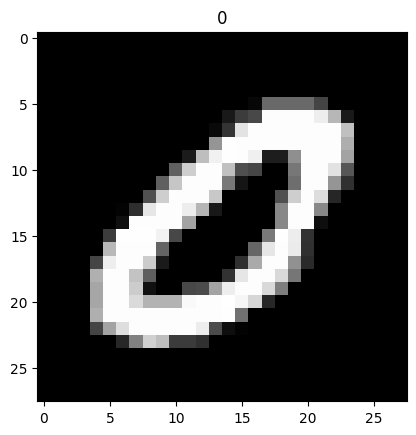

In [33]:
# code for visulization
idx= 1

image, label= trainset[idx]

print(image.shape)
print(image.permute(1,2,0).shape)
plt.imshow(image.permute(1,2,0), cmap='gray')
plt.title(label);

In [34]:
# LOAD DATASET into batches
from torch.utils.data import DataLoader

In [35]:
bs = 64
trainloader= DataLoader(trainset, batch_size= bs, shuffle= True)
validloader= DataLoader(validset, batch_size=bs)
testloader= DataLoader(testset, batch_size=bs)


In [36]:
print(len(trainloader))
print(len(validloader))
print(len(testloader))

782
157
157


In [37]:
for images, labels in trainloader:
  print(f"One image batch shape : {images.shape}")
  print(f"One labels batch shape : {labels.shape}")
  break;

One image batch shape : torch.Size([64, 1, 28, 28])
One labels batch shape : torch.Size([64])


# LOAD MODEL

In [38]:
# Define a custom neural network class that inherits from nn.Module
class MyModel(nn.Module):
    def __init__(self):
        # Call the constructor of the parent class (nn.Module)
        super(MyModel, self).__init__()

        # Define the convolutional block of the neural network
        self.cnn_block = nn.Sequential(
            # First convolutional layer with 1 input channel and 8 output channels
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3,3), padding=1),
            # Batch normalization for the 8 output channels of the first convolutional layer
            nn.BatchNorm2d(8),
            # ReLU activation function after the first convolutional layer
            nn.ReLU(),
            # Second convolutional layer with 8 input channels and 16 output channels
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3,3), padding=1),
            # Batch normalization for the 16 output channels of the second convolutional layer
            nn.BatchNorm2d(16),
            # ReLU activation function after the second convolutional layer
            nn.ReLU(),
            # Max pooling layer that reduces the spatial dimensions by a factor of 2
            nn.MaxPool2d(kernel_size=(2,2)),
            # Third convolutional layer with 16 input channels and 32 output channels
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), padding=1),
            # Batch normalization for the 32 output channels of the third convolutional layer
            nn.BatchNorm2d(32),
            # ReLU activation function after the third convolutional layer
            nn.ReLU(),
            # Another max pooling layer that further reduces the spatial dimensions by a factor of 2
            nn.MaxPool2d(kernel_size=(2,2))
        )

        # Define the linear (fully connected) block of the neural network
        self.linear_block = nn.Sequential(
            # Flatten the output of the convolutional block to make it suitable for the linear layers
            nn.Flatten(),
            # First linear layer that takes the flattened input and outputs 512 features
            nn.Linear(32*7*7, 512),
            # ReLU activation function after the first linear layer
            nn.ReLU(),
            # Dropout layer with a dropout probability of 0.5 to reduce overfitting
            nn.Dropout(p=0.5),
            # Second linear layer that takes the 512 input features and outputs 256 features
            nn.Linear(512, 256),
            # ReLU activation function after the second linear layer
            nn.ReLU(),
            # Another dropout layer with a dropout probability of 0.5 to further reduce overfitting
            nn.Dropout(p=0.5),
            # Final linear layer that takes the 256 input features and outputs 10 features,
            # which correspond to the class scores for a 10-class classification problem
            nn.Linear(256, 10)
        )

    def forward(self, images):
        # Define the forward pass through the network
        # First, pass the input images through the convolutional block
        x = self.cnn_block(images)
        # Then, pass the output of the convolutional block through the linear block
        logits = self.linear_block(x)
        # Return the final class logits
        return logits


model= MyModel()
model

MyModel(
  (cnn_block): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (linear_block): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1568, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features

# Create Train and Eval Function

In [39]:
import torch

def multiclass_accuracy(y_pred, y_true):
    """
    Calculates the accuracy of predictions for multi-class classification.

    Parameters:
    - y_pred: The predicted outputs from the model. This is a tensor of logits or probabilities
              for each class, where each row corresponds to a single example and each column
              corresponds to a class.
    - y_true: The true labels for each example. This is a tensor containing the actual class
              indices.

    Returns:
    - The accuracy as a float tensor, representing the proportion of correct predictions.
    """

    # Extract the top predicted class for each example.
    # topk(1, dim=1) returns the highest value along dimension 1 (columns) for each row.
    # top_p contains the top prediction probabilities, and top_class contains the corresponding class indices.
    top_p, top_class = y_pred.topk(1, dim=1)

    # Compare the predicted classes (top_class) with the true labels (y_true).
    # y_true.view(*top_class.shape) reshapes y_true to match the shape of top_class for element-wise comparison.
    # The result is a tensor of boolean values indicating correct (True) and incorrect (False) predictions.
    equals = top_class == y_true.view(*top_class.shape)

    # Calculate the mean accuracy.
    # equals.type(torch.FloatTensor) converts the boolean tensor to a float tensor, where True becomes 1.0 and False becomes 0.0.
    # torch.mean computes the mean of this tensor, resulting in the overall accuracy of the predictions.
    return torch.mean(equals.type(torch.FloatTensor))


In [40]:
def train_fn(model, dataloader, criterion, optimizer):

  model.train()
  total_loss=0.0
  total_acc= 0.0

  for images, labels in tqdm(dataloader):

    #images= images.to('cpu')
    #labels= labels.to('cpu')

    optimizer.zero_grad()
    logits= model(images)
    loss= criterion(logits, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    total_acc += multiclass_accuracy(logits, labels)

  return total_loss / len(dataloader), total_acc/len(dataloader)

In [41]:
def eval_fn(model, dataloader, criterion):

  model.eval()
  total_loss=0.0
  total_acc= 0.0

  with torch.no_grad():

    for images, labels in tqdm(dataloader):

      #images= images.to('cpu')
      #labels= labels.to('cpu')


      logits= model(images)
      loss= criterion(logits, labels)


      total_loss += loss.item()
      total_acc += multiclass_accuracy(logits, labels)

    return total_loss / len(dataloader), total_acc/len(dataloader)

# Training Loop

In [42]:
criterion = torch.nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(model.parameters(), lr=0.003)

In [43]:
best_valid_loss= np.Inf

for i in range(7):

  train_loss, train_acc= train_fn(model, trainloader, criterion, optimizer)
  valid_loss, valid_acc= eval_fn(model, trainloader, criterion)

  print(f"Epoch {i+1} Train Loss : {train_loss} Train Acc: {train_acc}")
  print(f"Epoch {i+1} Valid Loss : {valid_loss} Valid Acc: {valid_acc}")

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_weights.pt')
    print("SAVED-BEST-MODEL")
    best_valid_loss= valid_loss

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 1 Train Loss : 0.7860239271045951 Train Acc: 0.7292399406433105
Epoch 1 Valid Loss : 0.2635095835856312 Valid Acc: 0.9239130616188049
SAVED-BEST-MODEL


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 2 Train Loss : 0.392658258566771 Train Acc: 0.8769181370735168
Epoch 2 Valid Loss : 0.20229010653141363 Valid Acc: 0.9405171275138855
SAVED-BEST-MODEL


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 3 Train Loss : 0.312887047934334 Train Acc: 0.9042918682098389
Epoch 3 Valid Loss : 0.15580866677577004 Valid Acc: 0.9519860744476318
SAVED-BEST-MODEL


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 4 Train Loss : 0.27365956023869004 Train Acc: 0.9170995950698853
Epoch 4 Valid Loss : 0.12686554049653814 Valid Acc: 0.962236225605011
SAVED-BEST-MODEL


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 5 Train Loss : 0.24793464755234512 Train Acc: 0.9247322678565979
Epoch 5 Valid Loss : 0.12074470270277403 Valid Acc: 0.9647538065910339
SAVED-BEST-MODEL


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 6 Train Loss : 0.23635568686992006 Train Acc: 0.9282089471817017
Epoch 6 Valid Loss : 0.11420906740633766 Valid Acc: 0.9656130075454712
SAVED-BEST-MODEL


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 7 Train Loss : 0.219500221431141 Train Acc: 0.9314258098602295
Epoch 7 Valid Loss : 0.10971295758081442 Valid Acc: 0.9657328724861145
SAVED-BEST-MODEL


# Interfence

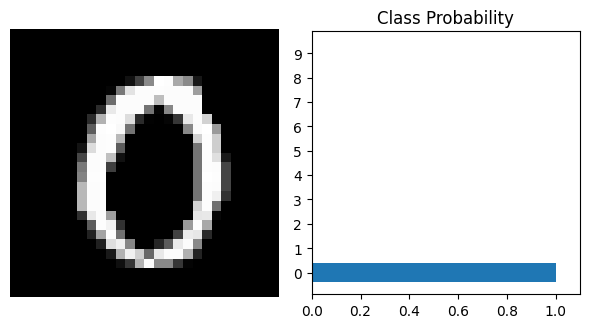

In [54]:
image, label = testset[13]

#load best weights
weights= torch.load('best_weights.pt')
model.load_state_dict(weights)

#evulate model
model.eval()
with torch.no_grad():
  logits= model(image.unsqueeze(0)) #(c,h,w) -> (1, c, h, w)
  ps = torch.nn.Softmax(dim=1)(logits)[0]
  view_classify(image, ps)


In [56]:
!pip install streamlit
!pip install streamlit_drawable_canvas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 42.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 51.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.6 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-24.0:
      Successfully uninstalled packaging-24.0


In [62]:
#APP PY
import cv2
import torch
import numpy as np
import streamlit as st
from streamlit_drawable_canvas import st_canvas
#from models import *
import plotly.graph_objects as go

# How to create website

In [74]:
# Display the title of the app
st.title('Digit Recognizer')

# Create two columns with equal width for layout
col1, col2 = st.columns([1, 1])

# Column 1: User input section
with col1:
    # Add some space before the checkbox for better layout
    for i in range(5):
        st.write(' ')

    # Checkbox to toggle between drawing and transforming mode
    mode = st.checkbox("Draw or Transform", True)

    # Streamlit Canvas for user input drawing
    # Users can draw digits on this canvas
    canvas_result = st_canvas(
        fill_color='#000000',  # Canvas fill color
        stroke_width=20,  # Width of the drawing pen
        stroke_color='#FFFFFF',  # Color of the pen
        background_color='#000000',  # Background color of the canvas
        width=256,  # Width of the canvas
        height=256,  # Height of the canvas
        drawing_mode="freedraw" if mode else "transform",  # Drawing mode
        key='canvas'
    )

    # Button for predicting the digit drawn on the canvas
    pred_button = st.button('Predict')

# Process the image from the canvas if it exists
if canvas_result.image_data is not None:
    # Resize the canvas image to 28x28 pixels for the model input
    img = cv2.resize(canvas_result.image_data.astype('uint8'), (28, 28))

    # Convert the image to grayscale since the model expects grayscale input
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Resulting shape (28, 28)

    # Normalize the image by dividing by 255 and add a channel dimension
    img = img[:, :, np.newaxis] / 255.0

# Column 2: Prediction and result visualization section
with col2:
    if pred_button:
        # Disable gradient calculations for prediction (inference mode)
        with torch.no_grad():
            # Convert the processed image to a PyTorch tensor and adjust dimensions
            # The expected dimension is (batch_size, channels, height, width)
            img = torch.Tensor(img).permute(2, 0, 1)

            # Get model logits for the input image
            logits = model(img.unsqueeze(0))  # Add a batch dimension

            # Apply softmax to convert logits to probabilities
            sm = torch.nn.Softmax(dim=1)
            probs = sm(logits)[0]  # Get probabilities for the first image in the batch

            # Create a bar plot of the digit probabilities using Plotly
            fig = go.Figure(
                data=[
                    go.Bar(
                        x=np.arange(0, 10),  # X-axis labels (0-9 digits)
                        y=(probs * 100).numpy()  # Y-axis values as probabilities
                    )
                ]
            )

            # Update figure layout for better visualization
            fig.update_layout(
                width=500,  # Width of the plot
                height=500  # Height of the plot
            )

            # Display the Plotly bar plot in the Streamlit app
            st.plotly_chart(fig)
